In [1]:
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection

In [2]:
tripdata_file_name = 'fhvhv_tripdata_2023-01.parquet'
shp_file_path = os.path.join('taxi_zones', 'taxi_zones.shp')
taxi_zone_lookup_file_name = 'taxi+_zone_lookup.csv'

Load Taxi Zone to Borough Lookup Dataframe

In [3]:
taxi_zone_lookup = pd.read_csv(taxi_zone_lookup_file_name)
display(taxi_zone_lookup)
zones_to_boroughs = pd.Series(taxi_zone_lookup.Borough.values, index=taxi_zone_lookup.LocationID).to_dict()
boroughs_to_zones = taxi_zone_lookup.groupby('Borough')['LocationID'].apply(lambda x: x.tolist()).to_dict()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


Load Trips Dataframe, add Borough data, cluster non-Manhattan Boroughs

In [4]:
trips = pq.read_table(tripdata_file_name)
trips = trips.to_pandas()
trips['PUBorough'] = trips['PULocationID'].map(zones_to_boroughs)
trips['DOBorough'] = trips['DOLocationID'].map(zones_to_boroughs)
trips['PULocationName'] = trips['PULocationID'].astype(object)
trips['DOLocationName'] = trips['DOLocationID'].astype(object)

non_manhattan_boroughs = set(trips['PUBorough'].unique()).union(set(trips['DOBorough'].unique()))
non_manhattan_boroughs.remove('Manhattan')
for borough in non_manhattan_boroughs:
    trips.loc[trips['PUBorough'] == borough, 'PULocationName'] = borough
    trips.loc[trips['DOBorough'] == borough, 'DOLocationName'] = borough
pd.set_option('display.max_columns', None)

In [5]:
print(trips.columns)
print("There are {} trips in {}.".format(len(trips), tripdata_file_name))
print(trips.dtypes)
locations_keys = trips.PULocationName.unique().tolist()
locations_keys.sort(key=lambda x: (isinstance(x, str), x))
locations = dict(zip(locations_keys, range(len(locations_keys))))
print(locations)

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'PUBorough', 'DOBorough',
       'PULocationName', 'DOLocationName'],
      dtype='object')
There are 18479031 trips in fhvhv_tripdata_2023-01.parquet.
hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles             

Group by (Origin, Destination, Departure Time at 15 min frequency), drop trips not including Manhattan, and find mean trip distance and trip duration

In [6]:
trips_gb = trips.groupby(['PULocationName', 'DOLocationName', trips.pickup_datetime.dt.floor('15T').dt.time])
trips_agg = trips_gb.size().to_frame(name='counts')
trips_agg = (trips_agg
    .join(trips_gb.agg({'trip_miles': 'mean'}).rename(columns={'trip_miles': 'trip_miles_mean'}))
    .join(trips_gb.agg({'trip_time': 'mean'}).rename(columns={'trip_time': 'trip_time_mean'}))
    .reset_index()
)
trips_agg = trips_agg.drop(trips_agg[(trips_agg['PULocationName'].isin(non_manhattan_boroughs)) & (trips_agg['DOLocationName'].isin(non_manhattan_boroughs))].index)
display(trips_agg)


,PULocationName,DOLocationName,pickup_datetime,counts,trip_miles_mean,trip_time_mean
0,4,4,00:00:00,3,1.366667,598.666667
1,4,4,00:15:00,8,2.608375,1069.750000
2,4,4,00:30:00,4,1.250250,675.250000
3,4,4,00:45:00,3,0.480000,188.000000
4,4,4,01:00:00,7,0.498143,333.857143
...,...,...,...,...,...,...
381686,Unknown,244,22:45:00,1,8.390000,1068.000000
381687,Unknown,246,18:00:00,1,12.902000,1741.000000
381688,Unknown,246,18:45:00,1,14.262000,2112.000000
381689,Unknown,249,13:00:00,1,20.812000,2498.000000


In [7]:
L = len(locations)
od_matrix = np.zeros((L, L, 24 * 4))
distance_matrix = np.zeros((L, L, 24 * 4))
duration_matrix = np.zeros((L, L, 24 * 4))
count = np.zeros((L, L, 24 * 4))
for i in trips_agg.index:
    idx = locations[trips_agg.loc[i, 'PULocationName']]
    idy = locations[trips_agg.loc[i, 'DOLocationName']]
    time_15 = int(trips_agg.loc[i, 'pickup_datetime'].hour + trips_agg.loc[i, 'pickup_datetime'].minute // 15)
    od_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'counts'])
    distance_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_miles_mean'])
    duration_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_time_mean'])
    count[idx, idy, time_15] += 1
count[count == 0] = 1
distance_matrix = np.divide(distance_matrix, count)  #?
duration_matrix = np.divide(duration_matrix, count)

In [8]:
np.save('od_matrix.npy', od_matrix)
np.save('distance_matrix.npy', distance_matrix)
np.save('duration_matrix.npy', duration_matrix)

<AxesSubplot: xlabel='pickup_datetime'>

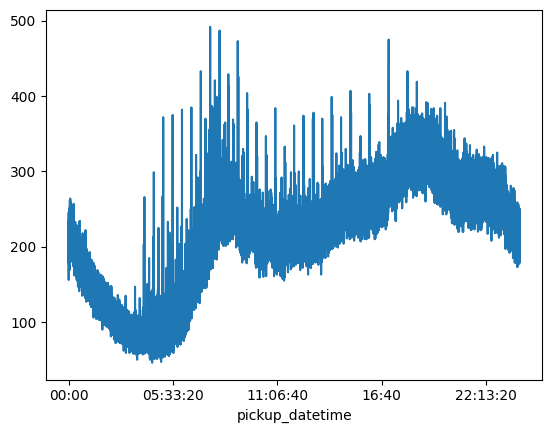

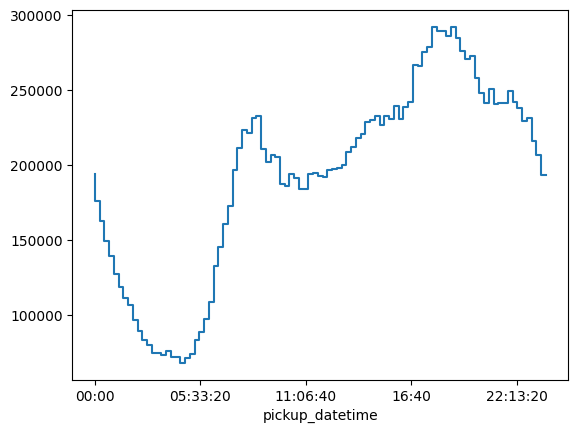

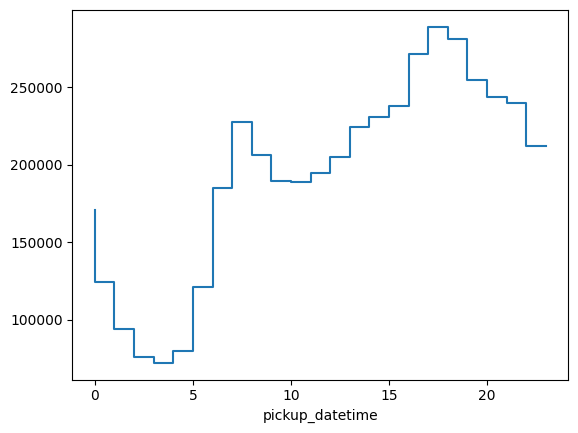

In [9]:
plt.figure()
trips_gb_time = trips.groupby(trips.pickup_datetime.dt.time).size().to_frame(name='counts')
trips_gb_time['counts'].plot(drawstyle='steps')
plt.figure()
trips_gb_time_15 = trips.groupby(trips.pickup_datetime.dt.floor('15T').dt.time).size().to_frame(name='counts')
trips_gb_time_15['counts'].plot(drawstyle='steps')
plt.figure()
trips_gb_time_hour_div_4 = trips.groupby(trips.pickup_datetime.dt.hour).size().to_frame(name='counts')
(trips_gb_time_hour_div_4['counts']/4).plot(drawstyle='steps')

In [10]:
NYC_map = gpd.read_file(shp_file_path)
NYC_map = NYC_map.set_index('LocationID')
NYC_map.index = NYC_map.index.astype(int)
NYC_map = NYC_map.sort_index()
NYC_map['LocationName'] = NYC_map.index.astype(object)
for borough in non_manhattan_boroughs:
    NYC_map.loc[NYC_map['borough'] == borough, 'LocationName'] = borough
    NYC_map.loc[NYC_map['borough'] == borough, 'LocationName'] = borough

L_NYC_map = len(NYC_map)
demand_arr_nyc = np.zeros(L_NYC_map)
demand_dep_nyc = np.zeros(L_NYC_map)
for l_NYC_map_idx, l in enumerate(NYC_map['LocationName']):
    if l in non_manhattan_boroughs:
        l_idx = locations[l]
        print(1, l, l_idx, od_matrix[:, l_idx, :].sum(), len(boroughs_to_zones[l]))
        demand_arr_nyc[l_NYC_map_idx] = od_matrix[:, l_idx, :].sum() / len(boroughs_to_zones[l])
        demand_dep_nyc[l_NYC_map_idx] = od_matrix[l_idx, :, ].sum() / len(boroughs_to_zones[l])
    elif l in locations:
        l_idx = locations[l]
        print(2, l, l_idx, od_matrix[:, l_idx, :].sum())
        demand_arr_nyc[l_NYC_map_idx] = od_matrix[:, l_idx, :].sum()
        demand_dep_nyc[l_NYC_map_idx] = od_matrix[l_idx, :, ].sum()
demand_arr = demand_arr_nyc / np.sum(demand_arr_nyc)
demand_dep = demand_dep_nyc / np.sum(demand_dep_nyc)
NYC_map['demand_dep'] = demand_dep
NYC_map['demand_arr'] = demand_arr

column_names = ['demand_dep', 'demand_arr']
titles = ['Distribution of Daily Total Travel Demand (Dep)',
          'Distribution of Daily Total Travel Demand (Arr)']

for column_name, title in zip(column_names, titles):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax1 = NYC_map.plot(ax=ax, column=column_name, cmap=plt.cm.get_cmap('OrRd'), legend=True, edgecolor='black')
    fig1 = ax1.figure
    plot_polygon_collection(ax, NYC_map['geometry'], values=NYC_map[column_name], cmap=plt.cm.get_cmap('OrRd'),
                            edgecolor='black')
    NYC_map.apply(lambda x: ax.annotate(int(x.name), xy=x.geometry.centroid.coords[0], ha='center', fontsize=5), axis=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=20)
    cb_ax = fig1.axes[1]
    cb_ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.show()



demand_arr[:14]

In [11]:
manh_map = NYC_map.copy()
manh_map = manh_map.drop(manh_map[(manh_map['borough'].isin(non_manhattan_boroughs)) & (manh_map['LocationName'].isin(non_manhattan_boroughs))].index)

In [12]:
L_map = len(manh_map)
demand_arr = np.zeros(L_map)
demand_dep = np.zeros(L_map)
for l_map_idx, l in enumerate(manh_map.index):
    if l in non_manhattan_boroughs:
        l_idx = locations[l]
        print(1, l, l_idx, od_matrix[:, l_idx, :].sum(), len(boroughs_to_zones[l]))
        demand_arr[l_map_idx] = od_matrix[:, l_idx, :].sum() / len(boroughs_to_zones[l])
        demand_dep[l_map_idx] = od_matrix[l_idx, :, ].sum() / len(boroughs_to_zones[l])
    elif l in locations:
        l_idx = locations[l]
        print(2, l, l_idx, od_matrix[:, l_idx, :].sum())
        demand_arr[l_map_idx] = od_matrix[:, l_idx, :].sum()
        demand_dep[l_map_idx] = od_matrix[l_idx, :, ].sum()
# demand_arr = demand_arr / np.sum(demand_arr)
# demand_dep = demand_dep / np.sum(demand_dep)
manh_map['demand_dep'] = demand_dep
manh_map['demand_arr'] = demand_arr
display(manh_map)

2 4 0 54480.0
2 12 1 2546.0
2 13 2 81138.0
2 24 3 25372.0
2 41 4 109659.0
2 42 5 159303.0
2 43 6 36636.0
2 45 7 44915.0
2 48 8 168259.0
2 50 9 93617.0
2 68 10 202884.0
2 74 11 124430.0
2 75 12 122230.0
2 79 13 237542.0
2 87 14 109954.0
2 88 15 41258.0
2 90 16 115187.0
2 100 17 102434.0
2 107 19 147553.0
2 113 20 104397.0
2 114 21 116225.0
2 116 22 80953.0
2 120 23 2028.0
2 125 24 55710.0
2 127 25 63617.0
2 128 26 5047.0
2 137 27 110429.0
2 140 28 120029.0
2 141 29 120764.0
2 142 30 127120.0
2 143 31 82060.0
2 144 32 121152.0
2 148 33 159998.0
2 151 34 51837.0
2 152 35 43524.0
2 153 36 14116.0
2 158 37 104016.0
2 161 38 215487.0
2 162 39 152814.0
2 163 40 138355.0
2 164 41 174628.0
2 166 42 82725.0
2 170 43 174698.0
2 186 44 156563.0
2 194 45 3339.0
2 202 46 13649.0
2 209 47 42007.0
2 211 48 103741.0
2 224 49 38551.0
2 229 50 102825.0
2 230 51 210496.0
2 231 52 194067.0
2 232 53 75197.0
2 233 54 106720.0
2 234 55 194759.0
2 236 56 154346.0
2 237 57 159342.0
2 238 58 96724.0
2 239 59 115

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,LocationName,demand_dep,demand_arr
LocationID,,,,,,,,,
4,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,63396.0,54480.0
12,12,0.036661,0.000042,Battery Park,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19...",12,2508.0,2546.0
13,13,0.050281,0.000149,Battery Park City,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20...",13,87819.0,81138.0
24,24,0.047000,0.000061,Bloomingdale,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23...",24,26584.0,25372.0
41,41,0.052793,0.000143,Central Harlem,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23...",41,117269.0,109659.0
...,...,...,...,...,...,...,...,...,...
246,246,0.069467,0.000281,West Chelsea/Hudson Yards,Manhattan,"POLYGON ((983031.177 217138.506, 983640.320 21...",246,199241.0,196605.0
249,249,0.036384,0.000072,West Village,Manhattan,"POLYGON ((983555.319 204876.901, 983469.158 20...",249,192329.0,167318.0
261,261,0.027120,0.000034,World Trade Center,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261,69336.0,67854.0


Convert TAZ Zones to Clusters

In [13]:
cluster_to_taz = {
            1: [128],
            2: [153, 127],
            3: [243],
            4: [244],
            5: [120],
            6: [116, 152],
            7: [42],
            8: [166, 24],
            9: [41],
            10: [74],
            11: [194],
            12: [151, 238],
            13: [43],
            14: [75, 236, 263, 262],
            15: [239, 143, 142],
            16: [237, 141, 140, 202],
            17: [50, 48],
            18: [160, 230, 161, 162, 163],
            19: [229],
            20: [246, 68],
            21: [100, 186, 164, 170],
            22: [233, 137],
            23: [158, 249],
            24: [90, 234, 113, 114],
            25: [107, 224, 79, 4],
            26: [125, 211, 144, 231],
            27: [148, 232, 45],
            28: [13, 261, 87, 209, 12, 88],
            29: [103]
}

def get_cluster(location):
    for cluster, taz in cluster_to_taz.items():
        if location in taz:
            return cluster
    return None

manh_map['Cluster'] = manh_map['LocationName'].apply(get_cluster)

In [14]:
print(manh_map.columns)

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'borough', 'geometry',
       'LocationName', 'demand_dep', 'demand_arr', 'Cluster'],
      dtype='object')


Aggregate clusters and geometry shapes according to TAZ 

In [15]:
manh_cluster = manh_map.copy()
manh_cluster = manh_cluster.dissolve(by='Cluster', aggfunc='sum')
print(manh_cluster)

                                                  geometry  OBJECTID  \
Cluster                                                                
1        MULTIPOLYGON (((1004617.108 259016.905, 100463...       128   
2        MULTIPOLYGON (((1005940.332 251332.077, 100593...       280   
3        POLYGON ((1003177.340 256097.318, 1003219.279 ...       243   
4        POLYGON ((1000658.690 249440.205, 1000658.740 ...       244   
5        POLYGON ((1005562.335 252189.432, 1005597.841 ...       120   
6        POLYGON ((999084.570 238238.230, 998997.418 23...       268   
7        POLYGON ((1002413.191 243934.560, 1002388.021 ...        42   
8        POLYGON ((995312.583 230027.442, 994915.661 23...       190   
9        POLYGON ((998716.913 234240.397, 999458.736 23...        41   
10       MULTIPOLYGON (((1004365.903 229760.981, 100427...        74   
11       POLYGON ((1007397.115 229906.118, 1007658.653 ...       194   
12       POLYGON ((992741.735 225381.885, 991955.565 22...      

c:\Users\celine\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [16]:
manh_cluster.to_file('manhattan_cluster.shp')

In [17]:
L = len(cluster_to_taz)
od_matrix = np.zeros((L, L, 24 * 4))
distance_matrix = np.zeros((L, L, 24 * 4))
duration_matrix = np.zeros((L, L, 24 * 4))
count = np.zeros((L, L, 24 * 4))
for i in trips_agg.index:
    idx = get_cluster(trips_agg.loc[i, 'PULocationName']) 
    idy = get_cluster(trips_agg.loc[i, 'DOLocationName'])
    if idx is None or idy is None:
        continue
    idx -= 1
    idy -= 1
    time_15 = int(trips_agg.loc[i, 'pickup_datetime'].hour + trips_agg.loc[i, 'pickup_datetime'].minute // 15)
    od_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'counts'])
    distance_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_miles_mean'])
    duration_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_time_mean'])
    count[idx, idy, time_15] += 1
count[count == 0] = 1
distance_matrix = np.divide(distance_matrix, count)  #?
duration_matrix = np.divide(duration_matrix, count)

In [18]:
np.save('od_matrix.npy', od_matrix)
np.save('distance_matrix.npy', distance_matrix)
np.save('duration_matrix.npy', duration_matrix)

C:\Users\celine\AppData\Local\Temp\ipykernel_22656\437351913.py:9: FutureWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  plot_polygon_collection(ax, map['geometry'], values=map[column_name], cmap=plt.cm.get_cmap('OrRd'),


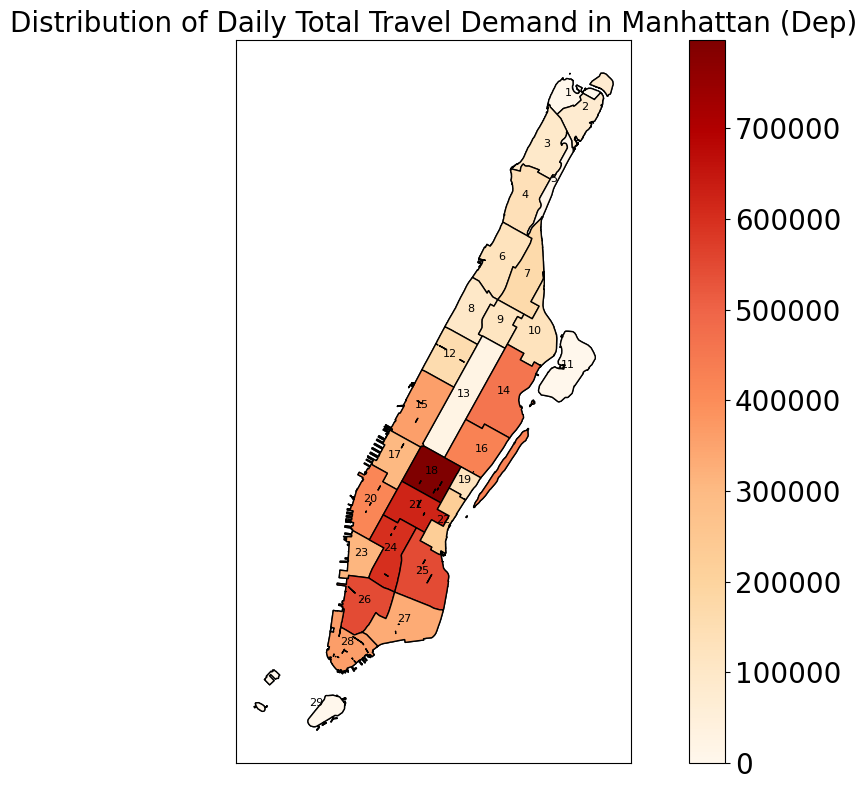

<Figure size 7680x5760 with 0 Axes>

C:\Users\celine\AppData\Local\Temp\ipykernel_22656\437351913.py:9: FutureWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  plot_polygon_collection(ax, map['geometry'], values=map[column_name], cmap=plt.cm.get_cmap('OrRd'),


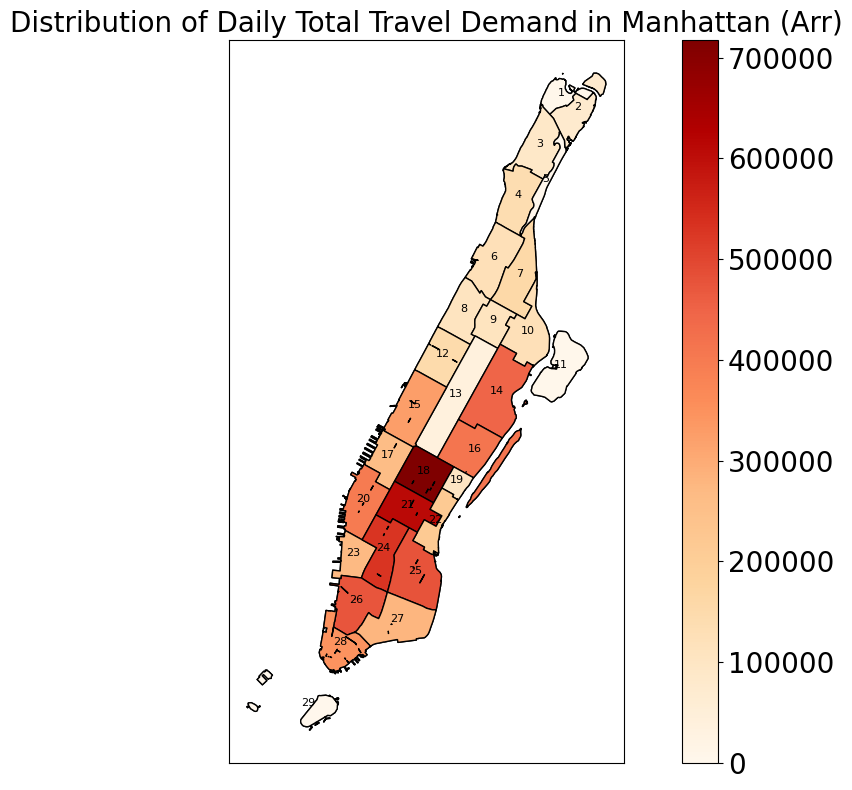

<Figure size 7680x5760 with 0 Axes>

In [19]:
column_names = ['demand_dep', 'demand_arr']
titles = ['Distribution of Daily Total Travel Demand in Manhattan (Dep)',
          'Distribution of Daily Total Travel Demand in Manhattan (Arr)']
def plot_map(titles, column_names, map):
    for column_name, title in zip(column_names, titles):
        fig, ax = plt.subplots(figsize=(12, 8))
        ax1 = map.plot(ax=ax, column=column_name, cmap=plt.cm.get_cmap('OrRd'), legend=True, edgecolor='black')
        fig1 = ax1.figure
        plot_polygon_collection(ax, map['geometry'], values=map[column_name], cmap=plt.cm.get_cmap('OrRd'),
                                edgecolor='black')
        map.apply(lambda x: ax.annotate(int(x.name), xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=20)
        cb_ax = fig1.axes[1]
        cb_ax.tick_params(labelsize=20)
        plt.tight_layout()
        plt.figure(dpi=1200)
        plt.show()

plot_map(titles, column_names, manh_cluster)



In [20]:

eta_charge = 0.90



spring_kwh_per_mi = 139 / 1000 * 1.609344 * eta_charge
spring_energy_matrix = distance_matrix * spring_kwh_per_mi
np.save('energies_2023_Dacia_Spring_Essential.npy', spring_energy_matrix)


In [21]:
print(spring_energy_matrix.shape)

(29, 29, 96)
